# Fidelity, hit measures and rules

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

import json
import gzip
import pickle
import datetime

from collections import defaultdict
from scipy.spatial.distance import hamming
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
dataset_list = ['yeast', 'woman','medical'] #, 'diabete']
blackbox_list = ['rf', 'svm', 'mlp']

In [3]:
hit_gdt = defaultdict(lambda: defaultdict(list))
rules_len_gdt = defaultdict(lambda: defaultdict(list))
gdt_labels = defaultdict(lambda: defaultdict(list))
gdt_rules = defaultdict(lambda: defaultdict(list))

for dataset in dataset_list:
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list:
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/GDT_to_mimic_%s_%s_metrics.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            #saving hit
            hit_gdt[dataset_name][bb_name].append(1.0 - r['hit_sm'])
            #saving rule lenght
            rules_len_gdt[dataset_name][bb_name].append(r['len_rule'])
            #saving rule
            gdt_rules[dataset_name][bb_name].append((r['i2e_id'],r['rule']))
            #saving label
            gdt_labels[dataset][bb_name].append(r['i2e_GDT_label'])
            
        resfile.close()

2018-11-10 10:20:45.067310 dataset: yeast
2018-11-10 10:20:45.067452 blackbox: rf
2018-11-10 10:20:45.100100 blackbox: svm
2018-11-10 10:20:45.128725 blackbox: mlp
2018-11-10 10:20:45.157201 dataset: woman
2018-11-10 10:20:45.157254 blackbox: rf
2018-11-10 10:20:45.334451 blackbox: svm
2018-11-10 10:20:45.513949 blackbox: mlp
2018-11-10 10:20:45.679529 dataset: medical
2018-11-10 10:20:45.679596 blackbox: rf
2018-11-10 10:20:45.744863 blackbox: svm
2018-11-10 10:20:45.811812 blackbox: mlp


### Comparison between mixed and union approaches

In [4]:
output_files = []
names_output = listdir('../output/')
for name in names_output:
    if name.startswith('20181103') or name.startswith('20181109'):
        output_files.append(name)
output_files

['20181103_0226_yeast_rf_explanationsandmetrics.json.gz',
 '20181109_0217_medical_mlp_explanationsandmetrics.json.gz',
 '20181109_0217_medical_rf_explanationsandmetrics.json.gz',
 '20181103_0228_woman_rf_explanationsandmetrics.json.gz',
 '20181103_0228_woman_svm_explanationsandmetrics.json.gz',
 '20181103_0226_yeast_svm_explanationsandmetrics.json.gz',
 '20181103_0227_yeast_mlp_explanationsandmetrics.json.gz',
 '20181103_0229_woman_mlp_explanationsandmetrics.json.gz',
 '20181109_0217_medical_svm_explanationsandmetrics.json.gz']

In [5]:
mixed_fidelity_sn = defaultdict(list)
mixed_fidelity_rn = defaultdict(list)
union_fidelity_sn = defaultdict(list)
union_fidelity_rn = defaultdict(list)

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            
            if r['fidelity_tree1_syn'] > 0 and r['fidelity_tree1_kNN'] > 0 and \
                r['fidelity_tree2_syn'] > 0 and r['fidelity_tree2_kNN'] > 0:

                mixed_fidelity_sn[bb_name].append(r['fidelity_tree1_syn'])
                mixed_fidelity_rn[bb_name].append(r['fidelity_tree1_kNN'])

                union_fidelity_sn[bb_name].append(r['fidelity_tree2_syn'])
                union_fidelity_rn[bb_name].append(r['fidelity_tree2_kNN'])

        resfile.close()

2018-11-10 10:20:45.901931 dataset: yeast
2018-11-10 10:20:45.902170 blackbox: rf
2018-11-10 10:20:45.946122 blackbox: svm
2018-11-10 10:20:45.983762 blackbox: mlp
2018-11-10 10:20:46.017926 dataset: woman
2018-11-10 10:20:46.017964 blackbox: rf
2018-11-10 10:20:46.226537 blackbox: svm
2018-11-10 10:20:46.432329 blackbox: mlp
2018-11-10 10:20:46.661237 dataset: medical
2018-11-10 10:20:46.661483 blackbox: rf
2018-11-10 10:20:46.697079 blackbox: svm
2018-11-10 10:20:46.732010 blackbox: mlp


In [6]:
values = []
print('Table 2')
for bb_name in blackbox_list:
    
    val = []
    print(bb_name)
    print('\tmixed fidelity sn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_sn[bb_name]), np.std(mixed_fidelity_sn[bb_name])))
    values.append(np.mean(mixed_fidelity_sn[bb_name]))
    values.append(np.std(mixed_fidelity_sn[bb_name]))            
    print('\tunion fidelity sn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_sn[bb_name]), np.std(union_fidelity_sn[bb_name])))
    values.append(np.mean(union_fidelity_sn[bb_name]))
    values.append(np.std(union_fidelity_sn[bb_name]))
    print('---')
    print('\tmixed fidelity rn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_rn[bb_name]), np.std(mixed_fidelity_rn[bb_name])))
    values.append(np.mean(mixed_fidelity_rn[bb_name]))
    values.append(np.std(mixed_fidelity_rn[bb_name]))
    print('\tunion fidelity rn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_rn[bb_name]), np.std(union_fidelity_rn[bb_name])))
    values.append(np.mean(union_fidelity_rn[bb_name]))
    values.append(np.std(union_fidelity_rn[bb_name]))

Table 2
rf
	mixed fidelity sn: 0.939 \pm 0.024
	union fidelity sn: 0.902 \pm 0.052
---
	mixed fidelity rn: 0.890 \pm 0.091
	union fidelity rn: 0.874 \pm 0.110
svm
	mixed fidelity sn: 0.913 \pm 0.048
	union fidelity sn: 0.875 \pm 0.073
---
	mixed fidelity rn: 0.652 \pm 0.205
	union fidelity rn: 0.678 \pm 0.213
mlp
	mixed fidelity sn: 0.928 \pm 0.071
	union fidelity sn: 0.911 \pm 0.109
---
	mixed fidelity rn: 0.677 \pm 0.221
	union fidelity rn: 0.682 \pm 0.213


In [7]:
print(r"""
\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches: averages and standard deviations of fidelity measures.}
\label{tab:neigh_comp}
\end{table}
""" % tuple(values))


\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & 0.94 $\pm$ 0.02 & 0.90 $\pm$ 0.05 & 0.89 $\pm$ 0.09 & 0.87 $\pm$ 0.11 \\
\textit{SVM} & 0.91 $\pm$ 0.05 & 0.87 $\pm$ 0.07 & 0.65 $\pm$ 0.20 & 0.68 $\pm$ 0.21 \\
\textit{MLP} & 0.93 $\pm$ 0.07 & 0.91 $\pm$ 0.11 & 0.68 $\pm$ 0.22 & 0.68 $\pm$ 0.21 \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches: averages and standard deviations of fidelity measures.}
\label{tab:neigh_comp}
\end{table}



In [8]:
mixed_fidelity_sn = defaultdict(lambda: defaultdict(list))
mixed_fidelity_rn = defaultdict(lambda: defaultdict(list))
union_fidelity_sn = defaultdict(lambda: defaultdict(list))
union_fidelity_rn = defaultdict(lambda: defaultdict(list))

for idx, dataset in enumerate(dataset_list):
    
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            
            if r['fidelity_tree1_syn'] > 0 and r['fidelity_tree1_kNN'] > 0 and \
                r['fidelity_tree2_syn'] > 0 and r['fidelity_tree2_kNN'] > 0:

                mixed_fidelity_sn[dataset_name][bb_name].append(r['fidelity_tree1_syn'])
                mixed_fidelity_rn[dataset_name][bb_name].append(r['fidelity_tree1_kNN'])

                union_fidelity_sn[dataset_name][bb_name].append(r['fidelity_tree2_syn'])
                union_fidelity_rn[dataset_name][bb_name].append(r['fidelity_tree2_kNN'])

        resfile.close()

2018-11-10 10:20:46.801890 dataset: yeast
2018-11-10 10:20:46.801944 blackbox: rf
2018-11-10 10:20:46.849295 blackbox: svm
2018-11-10 10:20:46.886436 blackbox: mlp
2018-11-10 10:20:46.928565 dataset: woman
2018-11-10 10:20:46.928632 blackbox: rf
2018-11-10 10:20:47.142016 blackbox: svm
2018-11-10 10:20:47.352454 blackbox: mlp
2018-11-10 10:20:47.567400 dataset: medical
2018-11-10 10:20:47.567490 blackbox: rf
2018-11-10 10:20:47.607240 blackbox: svm
2018-11-10 10:20:47.642549 blackbox: mlp


In [9]:
print('Table 2-bis fidelities for dataset')

values_fidelities_yeast = []
values_fidelities_woman = []
values_fidelities_medical = []

for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\ts-fidelity m-MARLENA %.3f pm %.3f, s-fidelity u-MARLENA %.3f pm %.3f' % ( 
            np.mean(mixed_fidelity_sn[dataset_name][bb_name]), np.std(mixed_fidelity_sn[dataset_name][bb_name]),
            np.mean(union_fidelity_sn[dataset_name][bb_name]), np.std(union_fidelity_sn[dataset_name][bb_name])))
        if dataset_name=='woman':
            values_fidelities_woman.append(np.mean(mixed_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_woman.append(np.std(mixed_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_woman.append(np.mean(union_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_woman.append(np.std(union_fidelity_sn[dataset_name][bb_name]))
        elif dataset_name=='yeast':
            values_fidelities_yeast.append(np.mean(mixed_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_yeast.append(np.std(mixed_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_yeast.append(np.mean(union_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_yeast.append(np.std(union_fidelity_sn[dataset_name][bb_name]))
        elif dataset_name=='medical':
            values_fidelities_medical.append(np.mean(mixed_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_medical.append(np.std(mixed_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_medical.append(np.mean(union_fidelity_sn[dataset_name][bb_name]))
            values_fidelities_medical.append(np.std(union_fidelity_sn[dataset_name][bb_name]))
            
            
        print('\t\tr-fidelity m-MARLENA %.3f pm %.3f, r-fidelity u-MARLENA %.3f pm %.3f' % ( 
            np.mean(mixed_fidelity_rn[dataset_name][bb_name]), np.std(mixed_fidelity_rn[dataset_name][bb_name]),
            np.mean(union_fidelity_rn[dataset_name][bb_name]), np.std(union_fidelity_rn[dataset_name][bb_name])))
        if dataset_name=='woman':
            values_fidelities_woman.append(np.mean(mixed_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_woman.append(np.std(mixed_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_woman.append(np.mean(union_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_woman.append(np.std(union_fidelity_rn[dataset_name][bb_name]))
        elif dataset_name=='yeast':
            values_fidelities_yeast.append(np.mean(mixed_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_yeast.append(np.std(mixed_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_yeast.append(np.mean(union_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_yeast.append(np.std(union_fidelity_rn[dataset_name][bb_name]))
        elif dataset_name=='medical':
            values_fidelities_medical.append(np.mean(mixed_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_medical.append(np.std(mixed_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_medical.append(np.mean(union_fidelity_rn[dataset_name][bb_name]))
            values_fidelities_medical.append(np.std(union_fidelity_rn[dataset_name][bb_name]))            

Table 2-bis fidelities for dataset
yeast
	 rf
		s-fidelity m-MARLENA 0.932 pm 0.030, s-fidelity u-MARLENA 0.923 pm 0.041
		r-fidelity m-MARLENA 0.893 pm 0.063, r-fidelity u-MARLENA 0.898 pm 0.057
	 svm
		s-fidelity m-MARLENA 0.840 pm 0.068, s-fidelity u-MARLENA 0.836 pm 0.079
		r-fidelity m-MARLENA 0.857 pm 0.084, r-fidelity u-MARLENA 0.862 pm 0.077
	 mlp
		s-fidelity m-MARLENA 0.904 pm 0.052, s-fidelity u-MARLENA 0.899 pm 0.065
		r-fidelity m-MARLENA 0.887 pm 0.064, r-fidelity u-MARLENA 0.891 pm 0.066
woman
	 rf
		s-fidelity m-MARLENA 0.941 pm 0.019, s-fidelity u-MARLENA 0.899 pm 0.047
		r-fidelity m-MARLENA 0.887 pm 0.094, r-fidelity u-MARLENA 0.866 pm 0.116
	 svm
		s-fidelity m-MARLENA 0.920 pm 0.025, s-fidelity u-MARLENA 0.885 pm 0.051
		r-fidelity m-MARLENA 0.571 pm 0.164, r-fidelity u-MARLENA 0.598 pm 0.181
	 mlp
		s-fidelity m-MARLENA 0.954 pm 0.020, s-fidelity u-MARLENA 0.944 pm 0.039
		r-fidelity m-MARLENA 0.616 pm 0.209, r-fidelity u-MARLENA 0.609 pm 0.191
medical
	 rf
		s-fi

In [10]:
print(r"""
\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches for the \emph{yeast} dataset: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp_yeast}
\end{table}
""" % tuple(values_fidelities_yeast))


\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & 0.93 $\pm$ 0.03 & 0.92 $\pm$ 0.04 & 0.89 $\pm$ 0.06 & 0.90 $\pm$ 0.06 \\
\textit{SVM} & 0.84 $\pm$ 0.07 & 0.84 $\pm$ 0.08 & 0.86 $\pm$ 0.08 & 0.86 $\pm$ 0.08 \\
\textit{MLP} & 0.90 $\pm$ 0.05 & 0.90 $\pm$ 0.06 & 0.89 $\pm$ 0.06 & 0.89 $\pm$ 0.07 \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches for the \emph{yeast} dataset: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp_yeast}
\end{table}



In [11]:
print(r"""
\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches for the \emph{woman} dataset: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp_woman}
\end{table}
""" % tuple(values_fidelities_woman))


\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & 0.94 $\pm$ 0.02 & 0.90 $\pm$ 0.05 & 0.89 $\pm$ 0.09 & 0.87 $\pm$ 0.12 \\
\textit{SVM} & 0.92 $\pm$ 0.03 & 0.88 $\pm$ 0.05 & 0.57 $\pm$ 0.16 & 0.60 $\pm$ 0.18 \\
\textit{MLP} & 0.95 $\pm$ 0.02 & 0.94 $\pm$ 0.04 & 0.62 $\pm$ 0.21 & 0.61 $\pm$ 0.19 \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches for the \emph{woman} dataset: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp_woman}
\end{table}



In [12]:
print(r"""
\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches for the \emph{medical} dataset: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp_medical}
\end{table}
""" % tuple(values_fidelities_medical))


\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{unified} & \textit{mixed} & \textit{unified} \\
 \hline
\textit{RF}  & 0.93 $\pm$ 0.06 & 0.90 $\pm$ 0.12 & 0.94 $\pm$ 0.09 & 0.97 $\pm$ 0.06 \\
\textit{SVM} & 0.95 $\pm$ 0.05 & 0.86 $\pm$ 0.14 & 0.92 $\pm$ 0.12 & 0.97 $\pm$ 0.06 \\
\textit{MLP} & 0.80 $\pm$ 0.12 & 0.72 $\pm$ 0.20 & 0.81 $\pm$ 0.20 & 0.89 $\pm$ 0.14 \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{unified} approaches for the \emph{medical} dataset: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp_medical}
\end{table}



## Hit performances MARLENA vs GDT

In [13]:
#saving hit values for MARLENA (both mixed and union)
hit_mixed = defaultdict(lambda: defaultdict(list))
hit_union = defaultdict(lambda: defaultdict(list))

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            
            if r['fidelity_tree1_syn'] > 0 and r['fidelity_tree1_kNN'] > 0 and \
                r['fidelity_tree2_syn'] > 0 and r['fidelity_tree2_kNN'] > 0:

                hit_mixed[dataset_name][bb_name].append(1.0 - r['hit_sm_tree1'])
                hit_union[dataset_name][bb_name].append(1.0 - r['hit_sm_tree2'])

        resfile.close()

2018-11-10 10:20:47.732319 dataset: yeast
2018-11-10 10:20:47.732412 blackbox: rf
2018-11-10 10:20:47.780090 blackbox: svm
2018-11-10 10:20:47.822288 blackbox: mlp
2018-11-10 10:20:47.860382 dataset: woman
2018-11-10 10:20:47.860445 blackbox: rf
2018-11-10 10:20:48.090755 blackbox: svm
2018-11-10 10:20:48.312712 blackbox: mlp
2018-11-10 10:20:48.528192 dataset: medical
2018-11-10 10:20:48.528252 blackbox: rf
2018-11-10 10:20:48.564257 blackbox: svm
2018-11-10 10:20:48.598535 blackbox: mlp


Table 3 e plot-MIXED
yeast
	 rf
		hit MARLENA 0.973 pm 0.046
		hit GDT 0.982 pm 0.037
	 svm
		hit MARLENA 0.949 pm 0.062
		hit GDT 0.932 pm 0.067
	 mlp
		hit MARLENA 0.970 pm 0.048
		hit GDT 0.942 pm 0.066
woman
	 rf
		hit MARLENA 0.951 pm 0.065
		hit GDT 0.985 pm 0.036
	 svm
		hit MARLENA 0.867 pm 0.091
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.819 pm 0.132
		hit GDT 0.988 pm 0.034
medical
	 rf
		hit MARLENA 0.998 pm 0.007
		hit GDT 0.999 pm 0.005
	 svm
		hit MARLENA 0.996 pm 0.010
		hit GDT 0.995 pm 0.012
	 mlp
		hit MARLENA 0.995 pm 0.012
		hit GDT 0.994 pm 0.013


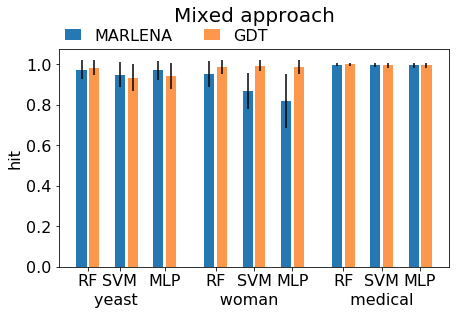

In [14]:
print('Table 3 e plot-MIXED')
plt.figure(figsize=(7,4))
index = 0
label_M = ''
label_GDT = ''

for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_mixed[dataset_name][bb_name]), np.std(hit_mixed[dataset_name][bb_name])))
        if label_M=='':
            label_M='MARLENA'
        else:
            label_M=None
        plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]),\
                yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2',label=label_M)
        index += 1
        
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if label_GDT=='':
            label_GDT='GDT'
        else:
            label_GDT=None
        plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]),\
                yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label=label_GDT)
        index +=2
    index += 1
    
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5, 20.5, 23.5, 26.5], ['RF', 'SVM', 'MLP']*3)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Mixed approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                woman              medical', fontsize=16)
plt.ylabel('hit',fontsize=16)
plt.savefig('../fig/MIXED_barplot.png', format='png', bbox_inches='tight')
plt.show()

In [15]:
values_hit = []
for bb_name in blackbox_list:
    for dataset_name in dataset_list:
        values_hit.append(np.mean(hit_mixed[dataset_name][bb_name]))
        values_hit.append(np.std(hit_mixed[dataset_name][bb_name]))
        values_hit.append(np.mean(hit_gdt[dataset_name][bb_name]))
        values_hit.append(np.std(hit_gdt[dataset_name][bb_name]))

print(r"""\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-m & GDT & MARLENA-m & GDT & MARLENA-m & GDT \\ \hline
\textit{RF} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\ \hline
\end{tabular}
\caption{Hit performance comparison (mean and standard deviation) between MARLENA-m and GDT trained on the instances to be explained.}
\label{tab:hit_mixed}
\end{table*}""" % tuple(values_hit))

\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-m & GDT & MARLENA-m & GDT & MARLENA-m & GDT \\ \hline
\textit{RF} & 0.97 $\pm$ 0.05 & 0.98 $\pm$ 0.04 & 0.95 $\pm$ 0.06 & 0.99 $\pm$ 0.04 & 1.00 $\pm$ 0.01 & 1.00 $\pm$ 0.01 \\
\textit{SVM} & 0.95 $\pm$ 0.06 & 0.93 $\pm$ 0.07 & 0.87 $\pm$ 0.09 & 0.99 $\pm$ 0.03 & 1.00 $\pm$ 0.01 & 0.99 $\pm$ 0.01 \\
\textit{MLP} & 0.97 $\pm$ 0.05 & 0.94 $\pm$ 0.07 & 0.82 $\pm$ 0.13 & 0.99 $\pm$ 0.03 & 0.99 $\pm$ 0.01 & 0.99 $\pm$ 0.01 \\ \hline
\end{tabular}
\caption{Hit performance comparison (mean and standard deviation) between MARLENA-m and GDT trained on the instances to be explained.}
\label{tab:hit_mixed}
\end{table*}


Table 3 e plot-UNION
yeast
	 rf
		hit MARLENA 0.969 pm 0.047
		hit GDT 0.982 pm 0.037
	 svm
		hit MARLENA 0.948 pm 0.061
		hit GDT 0.932 pm 0.067
	 mlp
		hit MARLENA 0.965 pm 0.052
		hit GDT 0.942 pm 0.066
woman
	 rf
		hit MARLENA 0.942 pm 0.066
		hit GDT 0.985 pm 0.036
	 svm
		hit MARLENA 0.874 pm 0.089
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.806 pm 0.117
		hit GDT 0.988 pm 0.034
medical
	 rf
		hit MARLENA 0.999 pm 0.004
		hit GDT 0.999 pm 0.005
	 svm
		hit MARLENA 0.998 pm 0.007
		hit GDT 0.995 pm 0.012
	 mlp
		hit MARLENA 0.996 pm 0.010
		hit GDT 0.994 pm 0.013


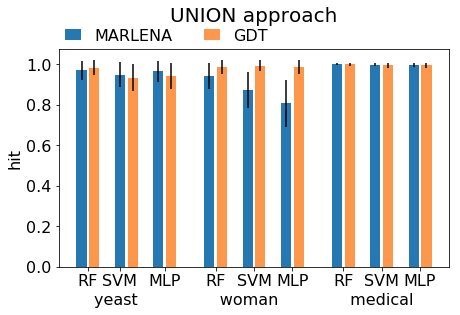

In [16]:
print('Table 3 e plot-UNION')
plt.figure(figsize=(7,4))
index = 0
label_M = ''
label_GDT = ''

for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_union[dataset_name][bb_name]), np.std(hit_union[dataset_name][bb_name])))
        if label_M=='':
            label_M='MARLENA'
        else:
            label_M=None
        plt.bar(index, np.mean(hit_union[dataset_name][bb_name]),\
                yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2',label=label_M)
        index += 1
        
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if label_GDT=='':
            label_GDT='GDT'
        else:
            label_GDT=None
        plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]),\
                yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label=label_GDT)
        index +=2
    index += 1
    
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5, 20.5, 23.5, 26.5], ['RF', 'SVM', 'MLP']*3)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('UNION approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                woman              medical', fontsize=16)
plt.ylabel('hit',fontsize=16)
plt.savefig('../fig/UNION_barplot.png', format='png', bbox_inches='tight')
plt.show()

In [17]:
values_hit = []
for bb_name in blackbox_list:
    for dataset_name in dataset_list:
        values_hit.append(np.mean(hit_union[dataset_name][bb_name]))
        values_hit.append(np.std(hit_union[dataset_name][bb_name]))
        values_hit.append(np.mean(hit_gdt[dataset_name][bb_name]))
        values_hit.append(np.std(hit_gdt[dataset_name][bb_name]))

print(r"""\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-u & GDT & MARLENA-u & GDT & MARLENA-u & GDT \\ \hline
\textit{RF} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\ \hline
\end{tabular}
\caption{Hit performance comparison (mean and standard deviation) between MARLENA-u and GDT trained on the instances to be explained.}
\label{tab:hit_union}
\end{table*}""" % tuple(values_hit))

\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-u & GDT & MARLENA-u & GDT & MARLENA-u & GDT \\ \hline
\textit{RF} & 0.97 $\pm$ 0.05 & 0.98 $\pm$ 0.04 & 0.94 $\pm$ 0.07 & 0.99 $\pm$ 0.04 & 1.00 $\pm$ 0.00 & 1.00 $\pm$ 0.01 \\
\textit{SVM} & 0.95 $\pm$ 0.06 & 0.93 $\pm$ 0.07 & 0.87 $\pm$ 0.09 & 0.99 $\pm$ 0.03 & 1.00 $\pm$ 0.01 & 0.99 $\pm$ 0.01 \\
\textit{MLP} & 0.96 $\pm$ 0.05 & 0.94 $\pm$ 0.07 & 0.81 $\pm$ 0.12 & 0.99 $\pm$ 0.03 & 1.00 $\pm$ 0.01 & 0.99 $\pm$ 0.01 \\ \hline
\end{tabular}
\caption{Hit performance comparison (mean and standard deviation) between MARLENA-u and GDT trained on the instances to be explained.}
\label{tab:hit_union}
\end{table*}


# Measures of rule lenght for the GDT

In [18]:
bb_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_labels = defaultdict(lambda: defaultdict(list))
union_marlena_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_rule_lenght = defaultdict(lambda: defaultdict(list))
union_marlena_rule_lenght = defaultdict(lambda: defaultdict(list))


for dataset in dataset_list:
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            bb_labels[dataset_name][bb_name].append(r['i2e_bb_label'])
            mixed_marlena_labels[dataset_name][bb_name].append(r['i2e_tree1_label']) 
            union_marlena_labels[dataset_name][bb_name].append(r['i2e_tree2_label']) 
            mixed_marlena_rule_lenght[dataset_name][bb_name].append(r['lenght_rule_tree1'])
            union_marlena_rule_lenght[dataset_name][bb_name].append(r['lenght_rule_tree2'])
        resfile.close()

2018-11-10 10:20:49.399829 dataset: yeast
2018-11-10 10:20:49.399978 blackbox: rf
2018-11-10 10:20:49.445393 blackbox: svm
2018-11-10 10:20:49.487338 blackbox: mlp
2018-11-10 10:20:49.523370 dataset: woman
2018-11-10 10:20:49.523430 blackbox: rf
2018-11-10 10:20:49.780947 blackbox: svm
2018-11-10 10:20:49.992321 blackbox: mlp
2018-11-10 10:20:50.206277 dataset: medical
2018-11-10 10:20:50.206360 blackbox: rf
2018-11-10 10:20:50.251866 blackbox: svm
2018-11-10 10:20:50.294785 blackbox: mlp


In [38]:
rule_len_values = []
for bb_name in blackbox_list:
    for dataset_name in dataset_list:
        mixed_mr = np.asarray(mixed_marlena_rule_lenght[dataset_name][bb_name])
        union_mr = np.asarray(union_marlena_rule_lenght[dataset_name][bb_name])
        gdt_mr = np.asarray(list(map(int, rules_len_gdt[dataset_name][bb_name])))
        
        rule_len_values.append(np.mean(mixed_mr))
        rule_len_values.append(np.std(mixed_mr))
        rule_len_values.append(np.mean(gdt_mr))
        rule_len_values.append(np.std(gdt_mr))

print(r"""\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-u & GDT & MARLENA & GDT & MARLENA-u & GDT \\ \hline
\textit{RF} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\ \hline
\end{tabular}
\caption{Mean rule length and standard deviation comparison between \mbox{MARLENA-m} and GDT trained on the instances to be explained.}
\label{tab:rule_len_mixed}
\end{table*}""" % tuple(rule_len_values))

\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-u & GDT & MARLENA & GDT & MARLENA-u & GDT \\ \hline
\textit{RF} & 2.92 $\pm$ 2.27 & 9.09 $\pm$ 3.35 & 4.30 $\pm$ 0.98 & 13.20 $\pm$ 4.56 & 1.41 $\pm$ 1.90 & 7.70 $\pm$ 3.12 \\
\textit{SVM} & 3.29 $\pm$ 2.24 & 5.68 $\pm$ 1.47 & 4.31 $\pm$ 1.51 & 16.30 $\pm$ 6.61 & 5.35 $\pm$ 1.67 & 11.76 $\pm$ 4.82 \\
\textit{MLP} & 2.44 $\pm$ 1.99 & 6.70 $\pm$ 2.36 & 2.93 $\pm$ 1.17 & 14.85 $\pm$ 6.17 & 4.58 $\pm$ 1.40 & 10.77 $\pm$ 5.40 \\ \hline
\end{tabular}
\caption{Mean rule length and standard deviation comparison between \mbox{MARLENA-m} and GDT trained on the instances to be explained.}
\label{tab:rule_len_mixed}
\end{table*}


In [39]:
rule_len_values = []

for bb_name in blackbox_list:
    for dataset_name in dataset_list:
        mixed_mr = np.asarray(mixed_marlena_rule_lenght[dataset_name][bb_name])
        union_mr = np.asarray(union_marlena_rule_lenght[dataset_name][bb_name])
        gdt_mr = np.asarray(list(map(int, rules_len_gdt[dataset_name][bb_name])))
        
        rule_len_values.append(np.mean(union_mr))
        rule_len_values.append(np.std(union_mr))
        rule_len_values.append(np.mean(gdt_mr))
        rule_len_values.append(np.std(gdt_mr))

print(r"""\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-u & GDT & MARLENA & GDT & MARLENA-u & GDT \\ \hline
\textit{RF} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\ \hline
\end{tabular}
\caption{Mean rule length and standard deviation comparison between MARLENA-u and GDT trained on the instances to be explained.}
\label{tab:rule_len_uni}
\end{table*}""" % tuple(rule_len_values))

\begin{table*}[t]
\setlength{\tabcolsep}{1mm}
\centering
\begin{tabular}{|c|cc|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{yeast} & \multicolumn{2}{c|}{woman} & \multicolumn{2}{c|}{medical} \\ \hline
\textit{Black Box} & MARLENA-u & GDT & MARLENA & GDT & MARLENA-u & GDT \\ \hline
\textit{RF} & 2.91 $\pm$ 2.44 & 9.09 $\pm$ 3.35 & 4.36 $\pm$ 1.19 & 13.20 $\pm$ 4.56 & 1.80 $\pm$ 2.01 & 7.70 $\pm$ 3.12 \\
\textit{SVM} & 3.18 $\pm$ 1.99 & 5.68 $\pm$ 1.47 & 4.36 $\pm$ 1.62 & 16.30 $\pm$ 6.61 & 4.31 $\pm$ 2.32 & 11.76 $\pm$ 4.82 \\
\textit{MLP} & 2.70 $\pm$ 2.30 & 6.70 $\pm$ 2.36 & 2.77 $\pm$ 1.42 & 14.85 $\pm$ 6.17 & 4.50 $\pm$ 1.75 & 10.77 $\pm$ 5.40 \\ \hline
\end{tabular}
\caption{Mean rule length and standard deviation comparison between MARLENA-u and GDT trained on the instances to be explained.}
\label{tab:rule_len_uni}
\end{table*}


In [33]:
rule_len_values = []
for dataset in dataset_list:
    print(dataset)
    for bb_name in blackbox_list:
        
        print('\t', bb_name)
        mixed_mr = np.asarray(mixed_marlena_rule_lenght[dataset][bb_name])
        union_mr = np.asarray(union_marlena_rule_lenght[dataset][bb_name])
        gdt_mr = np.asarray(list(map(int, rules_len_gdt[dataset][bb_name])))
        
        print('MARLENA-m mean rule lenght\t %.2f $\pm$ %.2f' % (np.mean(mixed_mr),np.std(mixed_mr)))
        rule_len_values.append(np.mean(mixed_mr))
        rule_len_values.append(np.std(mixed_mr))
        print('MARLENA-u mean rule lenght\t %.2f $\pm$ %.2f' % (np.mean(union_mr),np.std(union_mr)))
        rule_len_values.append(np.mean(union_mr))
        rule_len_values.append(np.std(union_mr))
        print('GDT: mean rule lenght\t\t %.2f $\pm$ %.2f' % (np.mean(gdt_mr),np.std(gdt_mr)))
        rule_len_values.append(np.mean(gdt_mr))
        rule_len_values.append(np.std(gdt_mr))

    print('')

yeast
	 rf
MARLENA-m mean rule lenght	 2.92 $\pm$ 2.27
MARLENA-u mean rule lenght	 2.91 $\pm$ 2.44
GDT: mean rule lenght		 9.09 $\pm$ 3.35
	 svm
MARLENA-m mean rule lenght	 3.29 $\pm$ 2.24
MARLENA-u mean rule lenght	 3.18 $\pm$ 1.99
GDT: mean rule lenght		 5.68 $\pm$ 1.47
	 mlp
MARLENA-m mean rule lenght	 2.44 $\pm$ 1.99
MARLENA-u mean rule lenght	 2.70 $\pm$ 2.30
GDT: mean rule lenght		 6.70 $\pm$ 2.36

woman
	 rf
MARLENA-m mean rule lenght	 4.30 $\pm$ 0.98
MARLENA-u mean rule lenght	 4.36 $\pm$ 1.19
GDT: mean rule lenght		 13.20 $\pm$ 4.56
	 svm
MARLENA-m mean rule lenght	 4.31 $\pm$ 1.51
MARLENA-u mean rule lenght	 4.36 $\pm$ 1.62
GDT: mean rule lenght		 16.30 $\pm$ 6.61
	 mlp
MARLENA-m mean rule lenght	 2.93 $\pm$ 1.17
MARLENA-u mean rule lenght	 2.77 $\pm$ 1.42
GDT: mean rule lenght		 14.85 $\pm$ 6.17

medical
	 rf
MARLENA-m mean rule lenght	 1.41 $\pm$ 1.90
MARLENA-u mean rule lenght	 1.80 $\pm$ 2.01
GDT: mean rule lenght		 7.70 $\pm$ 3.12
	 svm
MARLENA-m mean rule lenght	 5.35 $

## Rules qualitative evalutation

In [22]:
ICD9_code_descr_df = pd.read_excel('../dataset/ICD-9-CM-v32-master-descriptions/CMS32_DESC_LONG_SHORT_DX.xlsx')
ICD9_code_descr_df.rename(columns={'DIAGNOSIS CODE':'diag_code','LONG DESCRIPTION':'long_descr','SHORT DESCRIPTION':'short_descr'},inplace=True)

In [23]:
from skmultilearn.dataset import load_from_arff

data = load_from_arff("../dataset/dataset_raw/medical.arff",\
                      label_count=45,\
                      load_sparse=False,\
                      return_attribute_definitions=True)
cols_X = [i[0] for i in data[2]]
cols_Y = [i[0] for i in data[3]]

#### MARLENA

In [24]:
mixed_marlena_rule = defaultdict(lambda: defaultdict(list))
union_marlena_rule = defaultdict(lambda: defaultdict(list))

for dataset in dataset_list:
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            if r['fidelity_tree1_syn'] > 0 \
            and r['fidelity_tree1_kNN'] > 0 \
            and r['fidelity_tree2_syn'] > 0 \
            and r['fidelity_tree2_kNN'] > 0:
                if r['i2e_bb_label'] == r['i2e_tree1_label']:
                    mixed_marlena_rule[dataset_name][bb_name].append((r['i2e_id'],r['rule_tree1']))
                if r['i2e_bb_label'] == r['i2e_tree2_label']:
                    union_marlena_rule[dataset_name][bb_name].append((r['i2e_id'],r['rule_tree2']))
        
        resfile.close()

2018-11-10 10:20:51.385797 dataset: yeast
2018-11-10 10:20:51.385899 blackbox: rf
2018-11-10 10:20:51.431673 blackbox: svm
2018-11-10 10:20:51.472002 blackbox: mlp
2018-11-10 10:20:51.512637 dataset: woman
2018-11-10 10:20:51.512857 blackbox: rf
2018-11-10 10:20:51.781203 blackbox: svm
2018-11-10 10:20:52.009483 blackbox: mlp
2018-11-10 10:20:52.230572 dataset: medical
2018-11-10 10:20:52.230677 blackbox: rf
2018-11-10 10:20:52.272215 blackbox: svm
2018-11-10 10:20:52.320938 blackbox: mlp


In [25]:
potential_rules = []
for rule in mixed_marlena_rule['medical']['svm']:
    
    rule_antecedent = rule[1].split('[')[0]
    rule_consequence = rule[1].split('[')[1].strip(']')
    
    rule_consequence = ','.join(e for e in rule_consequence if e.isalnum())
    rule_consequence = [int(s) for s in rule_consequence.split(',') if s.isdigit()]
    rule_consequence = pd.Series(rule_consequence,index=cols_Y)
    rule_consequence = rule_consequence[rule_consequence.values==1]
    
    if len(rule_consequence[rule_consequence.values==1])>1:
        potential_rules.append((rule[0],rule_antecedent,rule_consequence))

In [26]:
diagnoses_rules = []

for potential_rule in potential_rules:
    diag_str_list = []
    for diagnoses in potential_rule[2].index.values:
        diagnosis = diagnoses.split('-')[2].replace('_', '')
        try:
            diagnosis_name = ICD9_code_descr_df[ICD9_code_descr_df.diag_code==diagnosis].long_descr.values[0]
        except:
            diagnosis_name = 'NA'
            print('error, diagnosis %s is not in database' % diagnosis)
        diag_str = ': '.join([diagnosis,diagnosis_name])
        diag_str_list.append(diag_str)
    diagnoses_rules.append((potential_rule[0],''.join([potential_rule[1],', '.join(diag_str_list)])))

error, diagnosis 7955 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database


In [27]:
diagnoses_rules[1]

('2',
 'duplication=0.0 <= 0.5, reflux=0.0 <= 0.5, hydronephrosis=1.0 > 0.5, normal=1.0 > 0.5, pyelectasis=1.0 > 0.5, mild=1.0 > 0.5 -> 78830: Urinary incontinence, unspecified, 591: Hydronephrosis')

#### GDT 

In [28]:
gdt_rules_understandable = []

for rule in gdt_rules['medical']['svm']:
    
    rule_antecedent = rule[1].split('[')[0]
    rule_consequence = rule[1].split('[')[1].strip(']')
    
    rule_consequence = ','.join(e for e in rule_consequence if e.isalnum())
    rule_consequence = [int(s) for s in rule_consequence.split(',') if s.isdigit()]
    rule_consequence = pd.Series(rule_consequence,index=cols_Y)
    rule_consequence = rule_consequence[rule_consequence.values==1]
    gdt_rules_understandable.append((rule[0],rule_antecedent,rule_consequence))

In [29]:
gdt_diagnoses_rules = []

for potential_rule in gdt_rules_understandable:
    diag_str_list = []
    for diagnoses in potential_rule[2].index.values:
        diagnosis = diagnoses.split('-')[2].replace('_', '')
        try:
            diagnosis_name = ICD9_code_descr_df[ICD9_code_descr_df.diag_code==diagnosis].long_descr.values[0]
        except:
            diagnosis_name = 'NA'
            print('error, diagnosis %s is not in database' % diagnosis)
        diag_str = ': '.join([diagnosis,diagnosis_name])
        diag_str_list.append(diag_str)
    gdt_diagnoses_rules.append((potential_rule[0],''.join([potential_rule[1],', '.join(diag_str_list)])))

error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7955 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7955 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7955 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7955 is not in database
error, diagnosis 7955 is not in database
error, diagnosis 7806 is not in database
error, diagnosis 7806 is not in database
error, diagnosis

In [30]:
gdt_diagnoses_rules[2]

('2',
 'cough=0.0 <= 0.5, reflux=0.0 <= 0.5, hydronephrosis=1.0 > 0.5, neurogenic=0.0 <= 0.5, pyelectasis=1.0 > 0.5 -> 78830: Urinary incontinence, unspecified, 591: Hydronephrosis')